# Notebook for visualizing streaming data

In [1]:
import fastplotlib as fpl 
import numpy as np
import zmq

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


# Setup zmq subscriber

In [2]:
context = zmq.Context()
sub = context.socket(zmq.SUB)
sub.setsockopt(zmq.SUBSCRIBE, b"")

# keep only the most recent message
sub.setsockopt(zmq.CONFLATE, 1)

# address must match publisher in Processor actor
sub.connect("tcp://127.0.0.1:5557")

<SocketContext(connect='tcp://127.0.0.1:5557')>

In [3]:
def get_buffer():
    """Gets the buffer from the publisher."""
    try:
        b = sub.recv(zmq.NOBLOCK)
    except zmq.Again:
        pass
    else:
        return b
    
    return None

# Create figure

In [4]:
figure = fpl.Figure(size=(1000, 900))

figure[0,0].axes.visible = False

RFBOutputContext()

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


In [5]:
def update_frame(p):
    """Update the frame using data received from the socket."""
    buff = get_buffer()
    if buff is not None:
        # Deserialize the buffer into a NumPy array
        data = np.frombuffer(buff, dtype=np.float64)

        data = data.reshape(384, 150)

        if len(p.graphics) == 0:
            p.add_line_stack(data, colors="gray", thickness=0.5, separation=55)
        else:
            for i in range(data.shape[0]):
                p.graphics[0][i].data[:, 1] = data[i]      

        p.auto_scale()

JupyterRenderCanvas(css_height='900.0px', css_width='1000.0px')
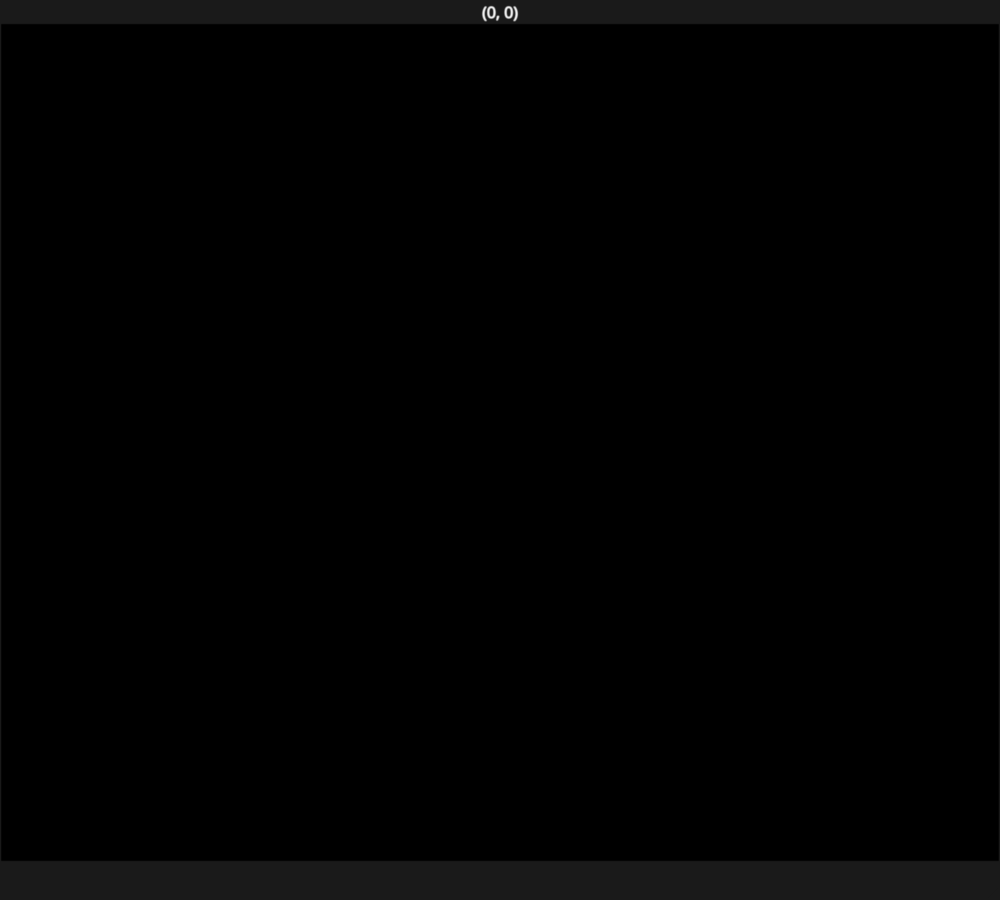

In [6]:
figure.show(maintain_aspect=False)

In [7]:
# Add the animation update function
figure[0, 0].add_animations(update_frame)